In [2]:
import torch
from utils import LQR_2D_true_solution, out_put, LQR_1D_true_solution, l_2_compute_1D_Q, l_2_compute_1D_V, true_V_eval_2D
from bases import bases_poly, d_bases_poly, sec_bases_poly, bases_2d, bases_poly_simp, d_bases_poly_simp, sec_bases_poly_simp, bases_2d_simp, bases_poly_2D, bases_poly_2D_s_a, d_bases_poly_2D, bases_poly_2D_simp, d_bases_poly_2D_simp, sec_d_bases_poly_2D, sec_d_bases_poly_2D_simp, bases_poly_2D_s_a_simp
from main_phibe import phibe_finder_1D_LQR, phibe_finder_2D_LQR
from main_RL import RL_finder_1D_LQR, RL_finder_2D_LQR
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

In [3]:
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

In [4]:
def reward(traj_mat, act_mat):
    # traj_mat shape: (m, I, dim)
    # act_mat shape: (m, I, dim)
    # output shape: (m, I, 1)
    r_1 = torch.einsum("ijk,kl,ijl->ij", traj_mat, Q, traj_mat)
    r_2 = torch.einsum("ijk,kl,ijl->ij", act_mat, R, act_mat)
    return (- r_1 - r_2).unsqueeze(-1)

In [33]:
beta = 0.
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [34]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [35]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [36]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [37]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.0843, -0.0795],
        [-0.0795, -0.0843]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.2061, -0.1724, -0.2061])
tensor([ 0.0000, -1.2388,  2.3277, -1.8926])


In [38]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 50
simp_basis = True
deterministic = True
b_val_phibe, V_exact_dist_phibe_1, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


In [39]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 50
simple_basis = True
b_val_RL, V_exact_dist_RL_1 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method: 100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


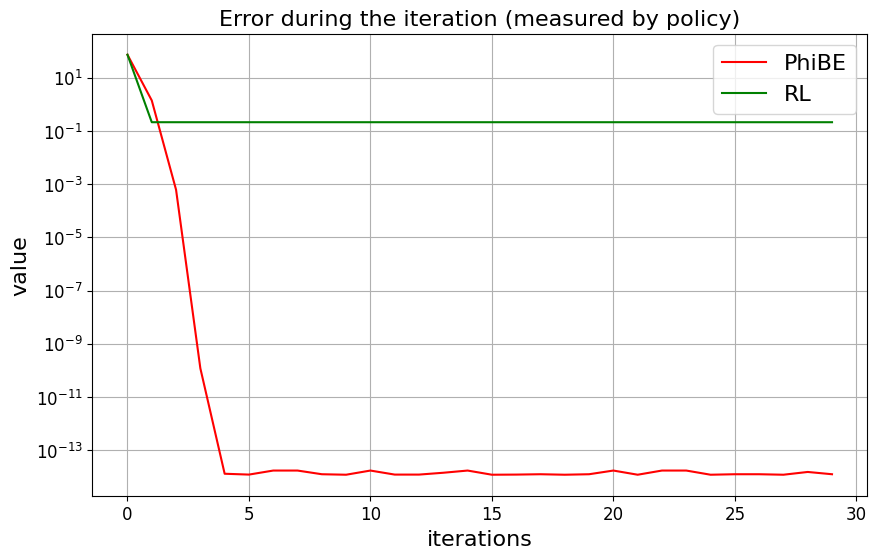

In [40]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_1[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_1[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [69]:
beta = 0.
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [70]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(2306.0366)


In [71]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [83]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [84]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.5646, -0.4237],
        [-0.4283, -0.5712]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.5690, -1.0791, -0.5668])
tensor([ 0.0000, -1.9168, -3.6875, -1.8298])


In [85]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simp_basis = True
deterministic = True
b_val_phibe_2, V_exact_dist_phibe_2, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


In [86]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 1
simple_basis = True
b_val_RL_2, V_exact_dist_RL_2 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:  37%|███▋      | 11/30 [00:07<00:12,  1.53it/s]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s]


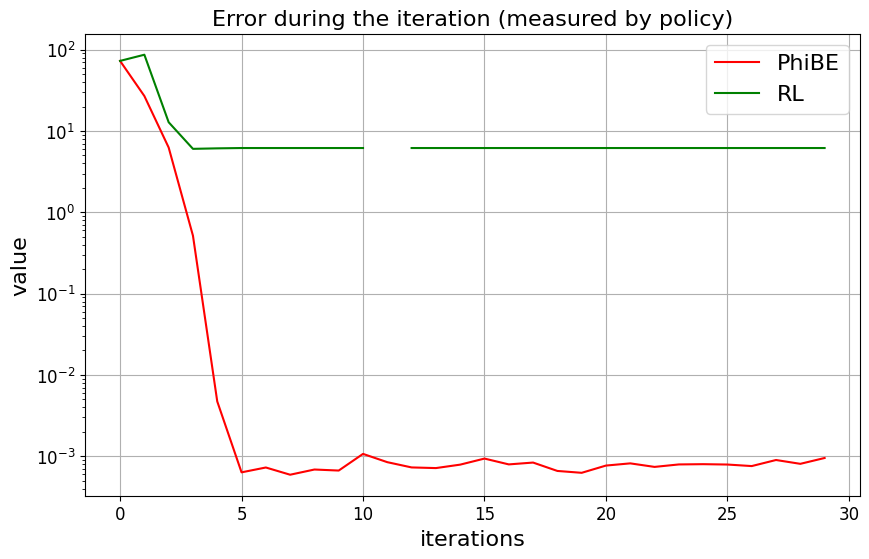

In [88]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_2[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_2[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [99]:
beta = 0.
A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
# A = 1 * torch.tensor([[-0.9, 0.85], [0.85, -0.88]])
# B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
# Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [100]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(25.0000)


In [101]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(102019.1848)


In [102]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [103]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-0.1104, -0.1104],
        [-0.1104, -0.1104]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -0.1749, -0.3418, -0.1749])
tensor([   0.0000, -393.0230,  219.2219,  -40.3157])


In [104]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simp_basis = True
deterministic = True
b_val_phibe_3, V_exact_dist_phibe_3, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:   3%|▎         | 1/30 [00:01<00:34,  1.19s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:   7%|▋         | 2/30 [00:02<00:29,  1.06s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  10%|█         | 3/30 [00:03<00:26,  1.03it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  13%|█▎        | 4/30 [00:03<00:23,  1.10it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  17%|█▋        | 5/30 [00:04<00:22,  1.13it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  20%|██        | 6/30 [00:05<00:20,  1.15it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


In [105]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.1
simple_basis = True
b_val_RL_3, V_exact_dist_RL_3 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:   3%|▎         | 1/30 [00:00<00:18,  1.56it/s]

infeasibility detected


Running RL method:   7%|▋         | 2/30 [00:01<00:17,  1.61it/s]

infeasibility detected


Running RL method:  10%|█         | 3/30 [00:01<00:16,  1.63it/s]

infeasibility detected


Running RL method:  20%|██        | 6/30 [00:03<00:15,  1.53it/s]

infeasibility detected


Running RL method:  27%|██▋       | 8/30 [00:05<00:14,  1.54it/s]

infeasibility detected


Running RL method:  37%|███▋      | 11/30 [00:07<00:12,  1.55it/s]

infeasibility detected


Running RL method:  57%|█████▋    | 17/30 [00:11<00:08,  1.45it/s]

infeasibility detected


Running RL method:  80%|████████  | 24/30 [00:15<00:03,  1.52it/s]

infeasibility detected


Running RL method:  83%|████████▎ | 25/30 [00:16<00:03,  1.54it/s]

infeasibility detected


Running RL method:  93%|█████████▎| 28/30 [00:18<00:01,  1.51it/s]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


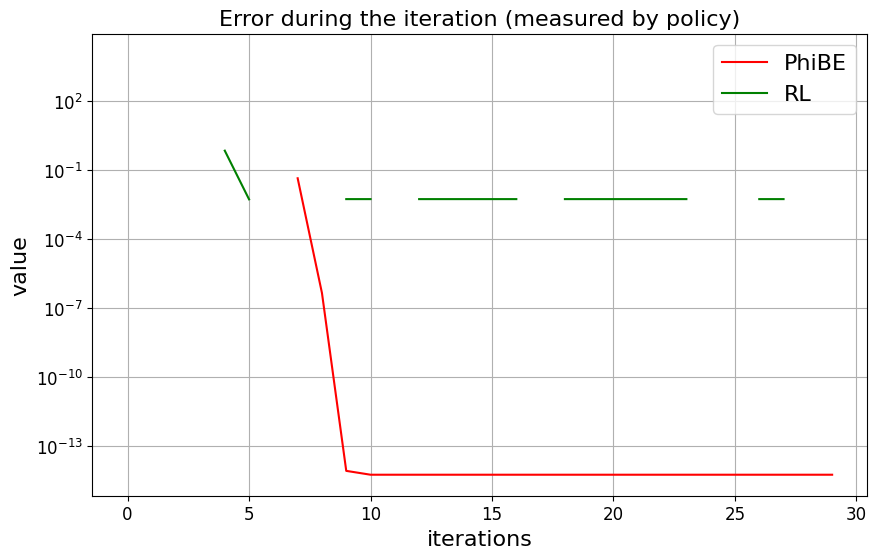

In [106]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_3[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_3[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [5]:
beta = 0.
# A =  torch.inverse(0.2 * torch.tensor([[-3.0, 1.0], [1., -3.0]]))
# B =  0.2 * torch.tensor([[3.0, 1.0], [1., 3.0]])
A = 1 * torch.tensor([[0.9, 0.899], [0.899, 0.88]])
B = 1 * torch.inverse(torch.tensor([[.4, 0.38], [0.38, 0.4]]))
# C = - 0.1 * torch.tensor([[2.0, 1.0], [1., 1.0]])
# D = 0.1 * torch.tensor([[3.0, 2.0], [.5, 1.0]])
sig = 0.
# Q = 1 * torch.tensor([[0.54, -0.86], [-0.86, 1.5]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.54, -0.26], [-0.26, 0.4]])
# R = 1 * torch.inverse(torch.tensor([[1.92, 0.4], [0.4, 0.3]]))
# Q = 1 * torch.tensor([[0.9, 0.89], [0.89, 0.9]])
# R = 1 * torch.inverse(torch.tensor([[.4, 0.398], [0.398, 0.4]]))
Q = 1 * torch.tensor([[0.9, 0.6], [0.6, 0.9]])
R = 1 * torch.inverse(torch.tensor([[.4, 0.3], [0.3, 0.4]]))

In [6]:
A_norm = torch.sqrt(torch.abs(torch.linalg.eig(A.T @ A).eigenvalues).max())
A_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(A).T @ torch.inverse(A)).eigenvalues).max())
B_norm = torch.sqrt(torch.abs(torch.linalg.eig(B.T @ B).eigenvalues).max())
B_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(B).T @ torch.inverse(B)).eigenvalues).max())
print(A_norm**2 * A_inv_norm * B_norm * B_inv_norm**2)

tensor(10751.9915)


In [7]:
Q_norm = torch.sqrt(torch.abs(torch.linalg.eig(Q.T @ Q).eigenvalues).max())
Q_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(Q).T @ torch.inverse(Q)).eigenvalues).max())
R_norm = torch.sqrt(torch.abs(torch.linalg.eig(R.T @ R).eigenvalues).max())
R_inv_norm = torch.sqrt(torch.abs(torch.linalg.eig(torch.inverse(R).T @ torch.inverse(R)).eigenvalues).max())
print(Q_norm**2 * Q_inv_norm * R_norm * R_inv_norm**2)

tensor(36.7500)


In [10]:
true_b, true_c, True_V = LQR_2D_true_solution(A, B, sig, Q, R, beta)
b_init = true_b + torch.randn(2, 2)
c_init = 2. * torch.rand(2, 1) - 1.
Q_init = 4. * torch.rand(10) - 2.
V_init = true_V_eval_2D(A, B, b_init, R, Q, beta, sig)

In [16]:
print(true_b)
print(true_c)
print(True_V)
print(V_init)

tensor([[-1.6591, -1.4832],
        [-1.4699, -1.6401]])
tensor([[0.],
        [0.]])
tensor([ 0.0000, -1.7558, -3.4488, -1.7622])
tensor([ 0.0000, -1.8545, -3.5322, -1.8067])


In [18]:
bd_low_s = -2
bd_upper_s = 2
bd_low_b = -2
bd_upper_b = 2
reward = reward
bases_V = bases_poly_2D_simp
d_bases_V = d_bases_poly_2D_simp
sec_d_bases_V = sec_d_bases_poly_2D_simp
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
lr=0.1
order = 1
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simp_basis = True
deterministic = True
b_val_phibe_4, V_exact_dist_phibe_4, V = phibe_finder_2D_LQR(beta, b_init, Q_init, bd_low_s, bd_upper_s, bd_low_b, bd_upper_b, reward, simp_basis, bases_V, d_bases_V, sec_d_bases_V, bases_Q, num_iter, deterministic, "Galerkin", GD_num_iter, m, m_Q, I, lr, dt, order, true_V, info_true)

Running Optimal Phibe of order 1 using Galerkin:  33%|███▎      | 10/30 [00:13<00:23,  1.18s/it]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  70%|███████   | 21/30 [00:25<00:08,  1.07it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  73%|███████▎  | 22/30 [00:26<00:07,  1.10it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin:  77%|███████▋  | 23/30 [00:26<00:06,  1.11it/s]

infeasibility detected


Running Optimal Phibe of order 1 using Galerkin: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it]


In [19]:
bd_low_s = -2
bd_upper_s = 2
bd_low_a = -2
bd_upper_a = 2
reward = reward
bases_Q = bases_poly_2D_s_a_simp
num_iter = 30
GD_num_iter = 75
m=int(1e6)
m_Q=int(1e6)
I=6
I_Q=6
true_V = True_V
info_true = {"A":A, "B":B, "sig":sig, "R":R, "Q":Q}
dt = 0.01
simple_basis = True
b_val_RL_4, V_exact_dist_RL_4 = RL_finder_2D_LQR(beta, b_init, bd_low_s, bd_upper_s, bd_low_a, bd_upper_a, reward, simple_basis, bases_Q, num_iter, I, m_Q, dt, true_V, info_true)

Running RL method:  23%|██▎       | 7/30 [00:04<00:14,  1.54it/s]

infeasibility detected


Running RL method:  43%|████▎     | 13/30 [00:08<00:11,  1.54it/s]

infeasibility detected


Running RL method:  47%|████▋     | 14/30 [00:09<00:10,  1.55it/s]

infeasibility detected


Running RL method: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]


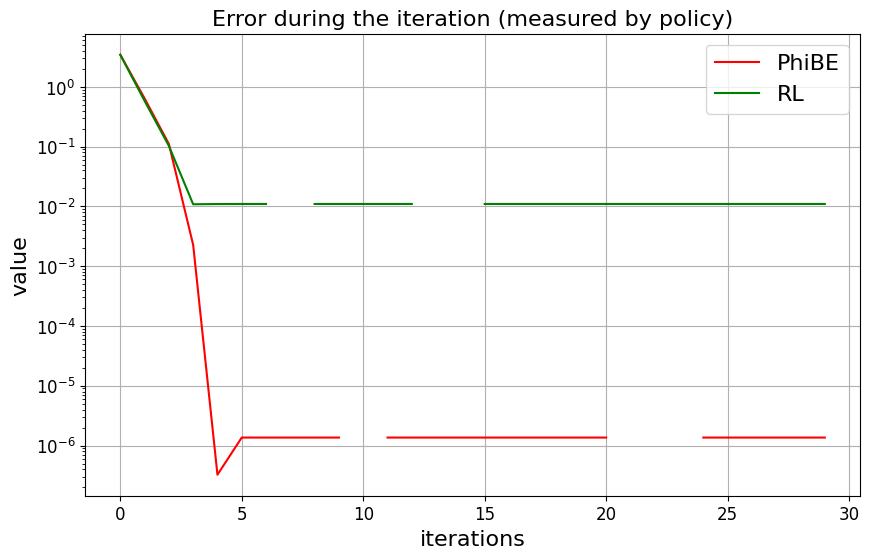

In [20]:
x_tensor = torch.arange(30)
w_tensor = torch.tensor(V_exact_dist_phibe_4[:30], dtype=torch.float64)
v_tensor = torch.tensor(V_exact_dist_RL_4[:30], dtype=torch.float64)
x_values = x_tensor.numpy()
w_values = w_tensor.numpy()
v_values = v_tensor.numpy()
plt.figure(figsize=(10, 6))
plt.xticks(fontsize=12)  # Adjust 12 as needed
plt.yticks(fontsize=12)
plt.semilogy(x_values, w_values, label='PhiBE', color='red')
plt.semilogy(x_values, v_values, label='RL', color='green')
plt.title('Error during the iteration (measured by policy)', fontsize=16)
plt.xlabel('iterations', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.show()